# Tutorial 04: Running an anomaly detector

Anti-Flow is designed to support exploring cyber-attacks on intelligent transportation systems. This consists both of designing and testing different attack scenarios, as well as designing and testing detection techniques to try and catch said attacks. This tutorial focuses on the design of anomaly detectors. 

First, let's rerun a simple ring simulation with no attacks. In utils.py version of both run_ring_sim_no_attack() and run_ring_sim_with_attack() are implemented which we can import here. run_ring_sim_with_attack() is slightly altered to accept any generic adversarial controller as an input.

In [1]:
import utils

sim_res_list_no_attack = utils.run_ring_sim_no_attack()

Running ring simulation, ring length: 300


/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/anti_flow/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Round 0, Return: 3681.4658716879394
data/ring_no_attack_20221013-1343261665686606.909197-0_emission.csv data
Average, std velocities: 7.405151224793998, 0.0
Average, std outflows: 0.0, 0.0
Average, std avg_trip_energy: nan, nan
Average, std avg_trip_time: nan, nan
Average, std total_completed_trips: 0.0, 0.0
Average, std returns: 3681.4658716879394, 0.0
Total time: 25.508980989456177
steps/second: 226.1583395591139


Just as in <PATH_TO_ANTIFLOW>\Adversaries there are a collection of different designs for adversaries in the traffic, in <PATH_TO_ANTIFLOW>\Detectors a collection of anomaly detection techniques can be found. Both of these are subject to ongoing edits and additions.

In Detectors\Deep_Learning\AutoEncoders a number of trained detection models exist, as well as functions to aid in training and testing new models. Let's first look at using a model trained for detection on a more complicated network to see the general structure. 

It may be important that the user make sure they have an updated version of PyTorch to be able to load in the given model. On my machine I was able to using version 1.7.1

In [2]:
#Import relevant libraries:
import numpy as np
import flow.visualize.visualize_ring as visualize_ring

import torch
print(torch.__version__)

# Anti-Flow specific functions for  detection:
from Detectors.Deep_Learning.AutoEncoders.utils import sliding_window
from Detectors.Deep_Learning.AutoEncoders.cnn_lstm_ae import CNNRecurrentAutoencoder

1.7.1


In [3]:
#Define appropriate model parameters. Don't change these if you want
#to load in the given model.

#Network specific hyper-params:
embedding_dim = 32
cnn_channels = 8
kernel_size = 16
stride = 1
batch_size = 16
device = 'cpu' #Change to cuda if appropriate
n_features=1 #Number of features, in the case only 1: speed
seq_len = 100 #How many samples from the time-series we look at per time

#initialize the CNN LSTM AutoEncoder:
model = CNNRecurrentAutoencoder(seq_len,
                                n_features,
                                embedding_dim,
                                cnn_channels, 
                                kernel_size, 
                                stride, 
                                device)

# Load in a trained model:
MODEL_PATH = '../Detectors/Deep_Learning/AutoEncoders/Models/Trained_RDA_Detect/cnn_lstm_ae_high_congestion_speed.pt'
model.load_state_dict(torch.load(MODEL_PATH,map_location=torch.device(device)))

<All keys matched successfully>

IMPORTANT NOTE: We do NOT recommend using this model for anything outside of reproducing the results for the paper in which it was developed. This was developed for a specific traffic regime/model and may not translate to well to different contexts. Here we use it as an example.

This detector uses only speed timeseries data from vehicles, and looks at a window of 100 consecutive measurements. To test it on our simulation we need to extract the speed timeseries for each vehicle.

Let's load in trajectories from the simulation:

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flow.visualize.visualize_ring as visualize_ring

emission_path = os.path.join(os.getcwd(),sim_res_list_no_attack[1])

timeseries_dict = visualize_ring.get_sim_timeseries(csv_path = emission_path,
                                                    warmup_period=50.0)
# Store speeds here:
speeds = []
for veh_id in timeseries_dict:
    speeds.append(timeseries_dict[veh_id][:,1])

Data loaded, total time: 0.7239091396331787


Let's now use the trained model on the loaded speed data. The sliding_window(model,input_data) function accepts an AE model and a  (n x 1) numpy array of timeseries data and slides the model across the data with a window length of seq_len. input_data must be longer than seq_len.

In [5]:
import time
import sys

begin_time = time.time()

i = 0
per_sample_computer_time = time.time()

losses = []
for speed in speeds:
    p,l = sliding_window(model,speed)
    losses.append(l)
    i += 1
    sys.stdout.write('\r'+'Vehicle, '+str(i)+' compute time: '+str(time.time()-per_sample_computer_time))
    per_sample_computer_time = time.time()
    
end_time = time.time()

print('Losses found, compute time: '+str(end_time-begin_time))

Vehicle, 20 compute time: 4.18456506729126Losses found, compute time: 90.31806898117065


Let's now visualize the loss results:

Text(0, 0.5, 'Loss value')

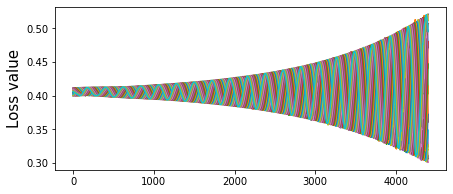

In [6]:
plt.figure(figsize=[7,3])

for loss in losses:
    plt.plot(loss)
plt.ylabel('Loss value',fontsize=15)

Here, larger loss values from the AutoEncoder indiciate that the corresponding portion of data was more anomalous. 

Another useful way to visualize anomalies in the traffic flow is to shade a space-time diagram with the losses. To do so we make use of two functions, get_loss_filter_indiv() and make_ring_spacetime_fig_with_losses(). The first averages loss values across time. The second creates a space-time plot and shades with respect to the loss:

In [7]:
# First reorganize the data

#Creates a rolling average loss value over time:
from Detectors.Deep_Learning.AutoEncoders.utils import get_loss_filter_indiv as loss_smooth

#Loads all data from simulation in, but doesn't format into numpy arrays:
full_sim_data_dict = visualize_ring.get_sim_data_dict_ring(csv_path = emission_path,warmup_period=50.0)

#veh ids for all vehicles in the flow:
veh_ids = list(timeseries_dict.keys())

#A dictionary which holds smoothed losses for vehicles:
smoothed_losses = dict.fromkeys(veh_ids)

#Get smoothed loss values:
for i in range(len(losses)):
    temp_veh_data = np.array(full_sim_data_dict[veh_ids[i]])
    time = temp_veh_data[:,0].astype(float)
    loss = losses[i]
    smoothed_losses[veh_ids[i]] =  loss_smooth(time,loss)


Data loaded.


Now we plot the spacetime diagram:

In [8]:
#Create the spacetime plot:
visualize_ring.make_ring_spacetime_fig_with_losses(smoothed_losses,
                                                   sim_data_dict=full_sim_data_dict,
                                                   ring_length=300)



TypeError: make_ring_spacetime_fig_with_losses() got multiple values for argument 'sim_data_dict'

For this detector it seems that fluctuations in the loss correlates strongly with the travling waves in the simulation, which is not surprising as speed fluctuations are cuased by the wave. One way we can use this data is to create a classifier for anamalous agents. A simple way to do such is to use the maximum loss seen for a given agent to determine whether or not that agent behaved anomalously.

In single class classification we might only have data coming from 

In [127]:
import utils
reload(utils)
reload(Adversaries.controllers.car_following_adversarial)

from Adversaries.controllers.car_following_adversarial import FollowerStopper_Overreact

# Define our advesary:
adversary = (FollowerStopper_Overreact, {'v_des':10,
                                        'braking_rate':-3.0,
                                        'braking_period':5.0})

Then we can run the simulation:

In [ ]:
sim_res_list_with_attack = utils.run_ring_sim_with_attack(adversary=adversary)

Before using the anomaly detector, let's visualize the attack in space-time:

Data loaded.


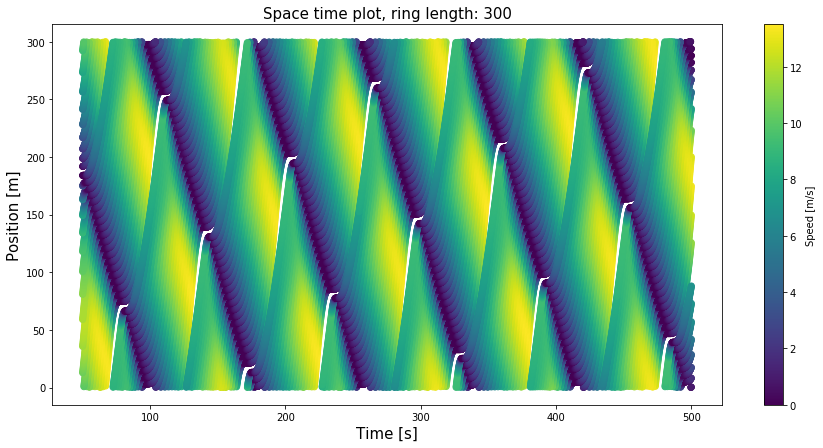

In [126]:
emission_path = os.path.join(os.getcwd(),sim_res_list_with_attack[1])
visualize_ring.make_ring_spacetime_fig(csv_path = emission_path)

Now, we perform the same data processing as before:

In [128]:
timeseries_dict_attack = visualize_ring.get_sim_timeseries(csv_path = emission_path,
                                                    warmup_period=50.0)
veh_ids_attack = list(timeseries_dict_attack.keys())

#Get speeds again:
speeds_attack = []
for veh_id in veh_ids_attack:
    speeds_attack.append(timeseries_dict_attack[veh_id][:,1])

print('Calculating losses...')
losses_attack = []
for speed in speeds_attack:
    p,l = sliding_window(model,speed)
    losses_attack.append(l)
print('Losses calculated.')

#Loads all data from simulation in, but doesn't format into numpy arrays:
full_sim_attack_data_dict = visualize_ring.get_sim_data_dict_ring(csv_path = emission_path,warmup_period=50.0)

#A dictionary which holds smoothed losses for vehicles:
smoothed_losses_attack = dict.fromkeys(veh_ids_attack)

#Get smoothed loss values:
for i in range(len(losses_attack)):
    temp_veh_data = np.array(full_sim_attack_data_dict[veh_ids_attack[i]])
    time = temp_veh_data[:,0].astype(float)
    loss = losses_attack[i]
    smoothed_losses_attack[veh_ids_attack[i]] = loss_smooth(time,loss)

print('Smoothed losses found.')

Data loaded.
Calculating losses...
Losses calculated.
Data loaded.
Smoothed losses found.


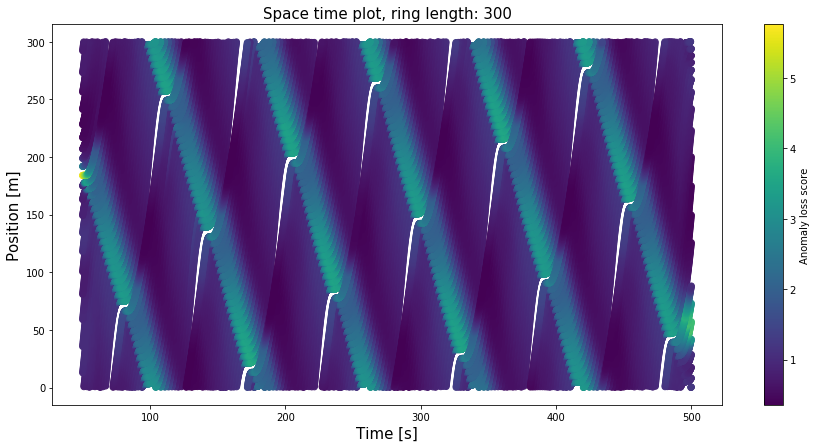

Analysis of attack finished.


In [129]:
#Create the spacetime plot shaded with losses:
visualize_ring.make_ring_spacetime_fig_with_losses(smoothed_losses_attack,
                                                   sim_data_dict=full_sim_attack_data_dict,
                                                   ring_length=300)

print('Analysis of attack finished.')
    

A core lesson here is that our detector doesn't really learn to isolate and detect the malicious AV. Rather, it appears to learn how to identify where a phantom jam/travelling wave has appeared. A possible solution here would be to rethink the feature set used. How might we choose a different set of inputs to our autoencoder that improve this behavior?